# Phase 5 Capstone Project
## Neural Style Transfer
### Authored by Trinity Gahagen
---
---

# Table of Contents

# EDA
---

In [9]:
# Basic imports
import numpy as np
import os
import matplotlib.pyplot as plt
import re

# Image tool imports
from PIL import Image
import cv2

# Deep learning imports
import tensorflow as tf
import tensorflow_hub as hub

In [6]:
CONTENT_DIRECTORY = "images/content/"
STYLES_DIRECTORY = "images/styles/"

In [7]:
content_names = os.listdir(CONTENT_DIRECTORY)
content_names

['beach.jpg',
 'bird_at_beach.jpg',
 'cat.jpg',
 'desert_1.jpg',
 'desert_2.jpg',
 'desert_3.jpg',
 'flower.jpg',
 'octopus.jpg',
 'person.jpg',
 'seashell.jpg',
 'sunset.jpg']

In [8]:
style_names = os.listdir(STYLES_DIRECTORY)
style_names

["at_the_water's_edge_.jpg",
 'chateau_noir_.jpg',
 'dance_hall_bellevue__obverse__.a.jpg',
 'el_rio_de_luz_(the_river_of_light)_.jpg',
 'flecks_of_foam_.jpg',
 'genesis_ii_.jpg',
 'glass_and_checkerboard_.jpg',
 'haystacks_in_brittany_.jpg',
 'keelmen_heaving_in_coals_by_moonlight_.jpg',
 'landscape_.jpg',
 'lumber_schooners_at_evening_on_penobscot_bay_.jpg',
 'melon_and_lemon_.jpg',
 'moonlight_.jpg',
 'new_york_.jpg',
 'place_du_carrousel,_paris_.jpg',
 'political_drama_.jpg',
 'red_path,_st._prex_.jpg',
 'salem_cove_.jpg',
 'seascape_(gravelines)_.jpg',
 'swiss_landscape_.jpg',
 'the_bend_in_the_road_.jpg',
 'the_evening_of_the_deluge_.jpg',
 'the_harvest_.jpg',
 'the_houses_of_parliament,_sunset_.jpg',
 'the_island_of_raguenez,_brittany_.jpg',
 'the_olive_orchard_.jpg',
 'the_peppermint_bottle_.jpg',
 'the_visit_-_couple_and_newcomer_.jpg',
 'the_watering_can_(emblems__the_garden)_.jpg',
 'two_poplars_in_the_alpilles_near_saint_-_remy_.jpg',
 'venice_.jpg',
 'weasels_at_play_.jpg'

In [10]:
style_paths = [os.path.join(STYLES_DIRECTORY, name) for name in style_names]
content_paths = [os.path.join(CONTENT_DIRECTORY, name) for name in content_names]

Text(0.5, 0, 'Folder')

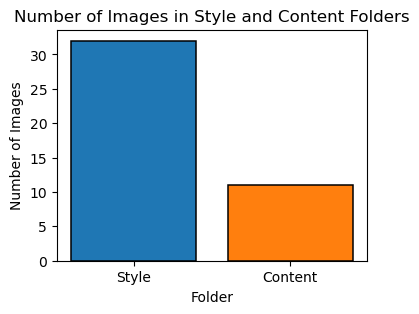

In [30]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x=[0, 1], height=[len(style_names), len(content_names)], lw=1.1, edgecolor='black', color=['tab:blue', 'tab:orange'])
ax.set_xticks([0, 1], labels=['Style', 'Content'])
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Style and Content Folders')
ax.set_xlabel('Folder')

In [11]:
example_styles = [Image.open(path) for path in style_paths]

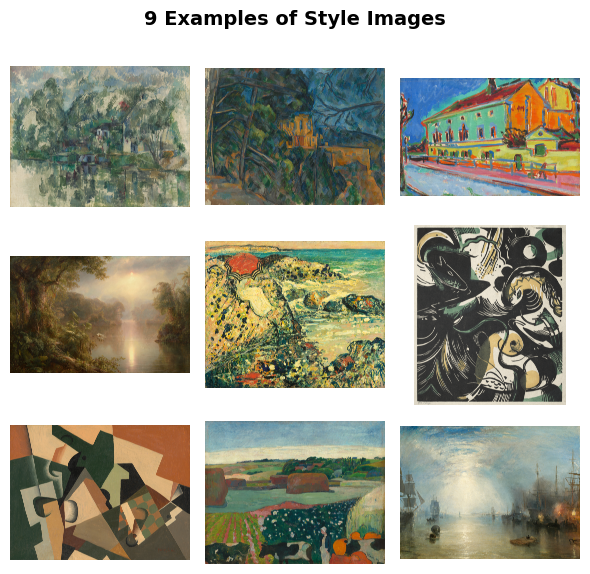

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle('9 Examples of Style Images', weight='bold', size=14)
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.set_axis_off()
    ax.imshow(example_styles[i])
plt.tight_layout();

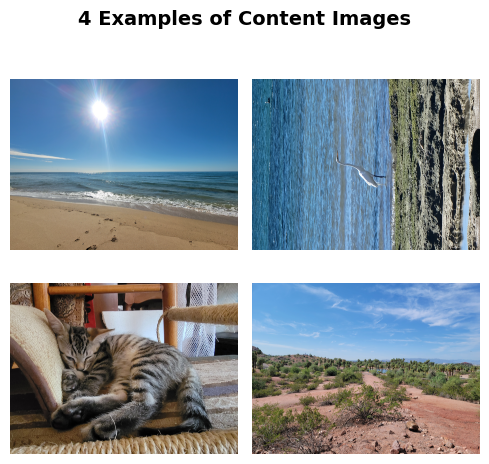

In [34]:
example_content = [Image.open(path) for path in content_paths]

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
fig.suptitle('4 Examples of Content Images', weight='bold', size=14)
for i in range(4):
    ax = axes[i // 2, i % 2]
    ax.set_axis_off()
    ax.imshow(example_content[i])
plt.tight_layout();

# External Sources
---
L. A. Gatys, A. S. Ecker and M. Bethge, "Image Style Transfer Using Convolutional Neural Networks," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 2414-2423, doi: 10.1109/CVPR.2016.265. keywords: {Image reconstruction;Neural networks;Image representation;Semantics;Neuroscience;Feature extraction;Visualization},

https://www.tensorflow.org/tutorials/generative/style_transfer